In [1]:
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import linear_model

# util functions 
import src.chihat_calculator_random_dct as chihat_calculator_random_dct
import src.chihat_calculator_gauss as chihat_calculator_gauss
import src.util as util


In [2]:
np.random.seed(0)

# set parameters

* $N$ : dim of true parameter
* $M$ : num of measurements
* $\gamma = \frac{M}{N}$: measurement ratio
* $\sigma^2$ : error variance
* $\varrho$ : sparseness of true parameter (true parameter is assumed to be $\varrho N$-sparse)

In [3]:
N = 1000
γ = 0.5
M = int(N * γ)
σ = np.sqrt(0.02)
ϱ = 0.1

# create synthetic data
* $x_0$ : true signal drwan from Berunoulli-Gaussian ensemble:
    * $x_{0,i} \sim_{\rm i.i.d.} (1-\varrho)\delta(x_{0,i}) + \varrho\mathcal N(0,1)$
* $A_{\rm gauss}$ : measurement matrix drawn from the random i.i.d. Gaussian ensemble
* $A_{\rm dct}$ : measurement matrix drawn from the random discrete cosine transform ensemble
* $y_{\rm gauss} = A_{\rm gauss}x_0 + \xi$
* $y_{\rm dct} = A_{\rm dct}x_0 + \xi$


In [4]:
# true parameter
x_0 = util.make_true_parameter(N, ϱ)

# observation matrix
A_gauss = util.make_gauss_matrix(M, N)
A_dct = util.make_random_dct_matrix(M, N)

# observed value
y_gauss = np.random.normal(A_gauss @ x_0, σ)
y_dct = np.random.normal(A_dct @ x_0, σ)

# LASSO
* get a LASSO estimator using sklearn 
* $\lambda$ is chosen by $40$-fold cross-validation

## choose $\lambda$ by k-fold cross validation

In [5]:
# gauss
lasso_cross_validation = linear_model.LassoCV(cv=40,
                                              fit_intercept=False,
                                              precompute=True,
                                              n_jobs=-1)
model_gauss = lasso_cross_validation.fit(A_gauss, y_gauss)
λ_gauss = model_gauss.alpha_ 

# dct
lasso_cross_validation = linear_model.LassoCV(cv=40,
                                              fit_intercept=False,
                                              precompute=True,
                                              n_jobs=-1)
model_dct = lasso_cross_validation.fit(A_dct, y_dct)
λ_dct = model_dct.alpha_ 


## get a LASSO estimator
* LASSO estimator is given by a coordinate decent algorithm
* m_gauss: LASSO estimator for Gaussian design
* m_dct: LASSO estimator for random DCT design

In [6]:
# gauss
lasso_model_gauss = linear_model.Lasso(
    alpha=λ_gauss,
    tol=1e-6,
    selection='cyclic',
    fit_intercept=False,
    max_iter=1e7)

result_gauss = lasso_model_gauss.fit(A_gauss, y_gauss)

m_gauss = result_gauss.coef_

# dct
lasso_model_dct = linear_model.Lasso(
    alpha=λ_dct,
    tol=1e-6,
    selection='cyclic',
    fit_intercept=False,
    max_iter=1e7)

result_dct = lasso_model_gauss.fit(A_dct, y_dct)

m_dct = result_dct.coef_

# De-biased estimator 

## de-biased estimator 
* $\rho_{\rm active}$ : active component density
* $\Lambda$ : Onsager coefficient
* $\chi$ : susceptibility
* $h$ : local field
* $x_{\rm debiased}$ : de-biased estimator

In [7]:
# active component density
ρ_active_gauss = np.sum(m_gauss != 0.0) / N
ρ_active_dct = np.sum(m_dct != 0.0) / N

# Onsager coefficient
Λ_gauss = (γ - ρ_active_gauss) / (1.0 - ρ_active_gauss)
Λ_dct = γ - ρ_active_dct

# susceptibility
χ_gauss = ρ_active_gauss / Λ_gauss
χ_dct = ρ_active_dct / Λ_dct

# local field
h_gauss = Λ_gauss * m_gauss + A_gauss.transpose() @ (y_gauss - A_gauss @ m_gauss)
h_dct = Λ_dct * m_dct + A_dct.transpose() @ (y_dct - A_dct @ m_dct)

# debiased estimator
x_debiased_gauss = h_gauss / Λ_gauss
x_debiased_dct = h_dct / Λ_dct

## variance of de-baiesd estimator
* rss: residual sum of squares
    * $\mathrm{RSS} =  \frac{1}{M}\|y-Am \|_2^2$
    
* $\sigma_{\rm estimate}^2 $ : estimate of error variance

In [8]:
# residual sum of squares
rss_gauss = np.linalg.norm(y_gauss - A_gauss @ m_gauss) ** 2.0 / M
rss_dct = np.linalg.norm(y_dct - A_dct @ m_dct) ** 2.0 / M

# heuristc error variance estimation
σ_estimate = np.sqrt(np.linalg.norm(y_dct - A_dct @ m_dct)**2.0 / (M - N * ρ_active_dct))

# χ_hat
χ_hat_gauss = chihat_calculator_gauss.calc_chi_hat(γ, rss_gauss)
χ_hat_dct = chihat_calculator_random_dct.calc_chi_hat(χ_dct, γ, rss_dct, σ_estimate)

# variance 
v_gauss = χ_hat_gauss / Λ_gauss ** 2.0
v_dct = χ_hat_dct / Λ_dct ** 2.0

# result 

## distribution of local fields
* Q-Q plots of $\left\{\frac{h_i - x_{0,i}\, \hat{Q}}{\sqrt{\hat{\chi}}} \right\}_i$ are shown

<IPython.core.display.Javascript object>


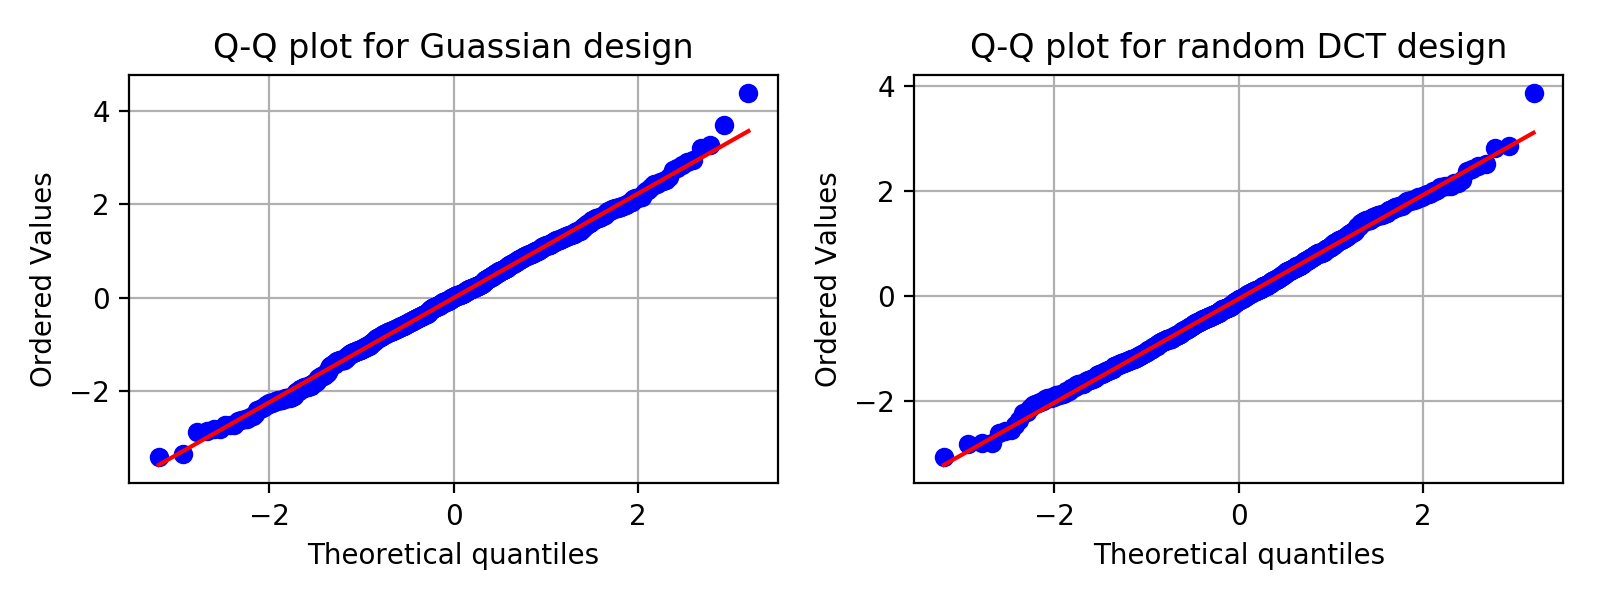

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(8,3))
# gauss
ax = fig.add_subplot(121)
z = (h_gauss - x_0 * Λ_gauss) / np.sqrt(χ_hat_gauss)
stats.probplot(z, dist="norm", plot=ax)
ax.grid()
ax.set_title("Q-Q plot for Guassian design")

# dct
ax = fig.add_subplot(122)
z = (h_dct - x_0 * Λ_dct) / np.sqrt(χ_hat_gauss)
stats.probplot(z, dist="norm", plot=ax)
ax.grid()
ax.set_title("Q-Q plot for random DCT design")


fig.tight_layout()


## de-biased estimator vs true parameter
* true parameter and de-biased estimator with confidence intervals are shown
* only first n_shown elements are shown for simplisity

<IPython.core.display.Javascript object>


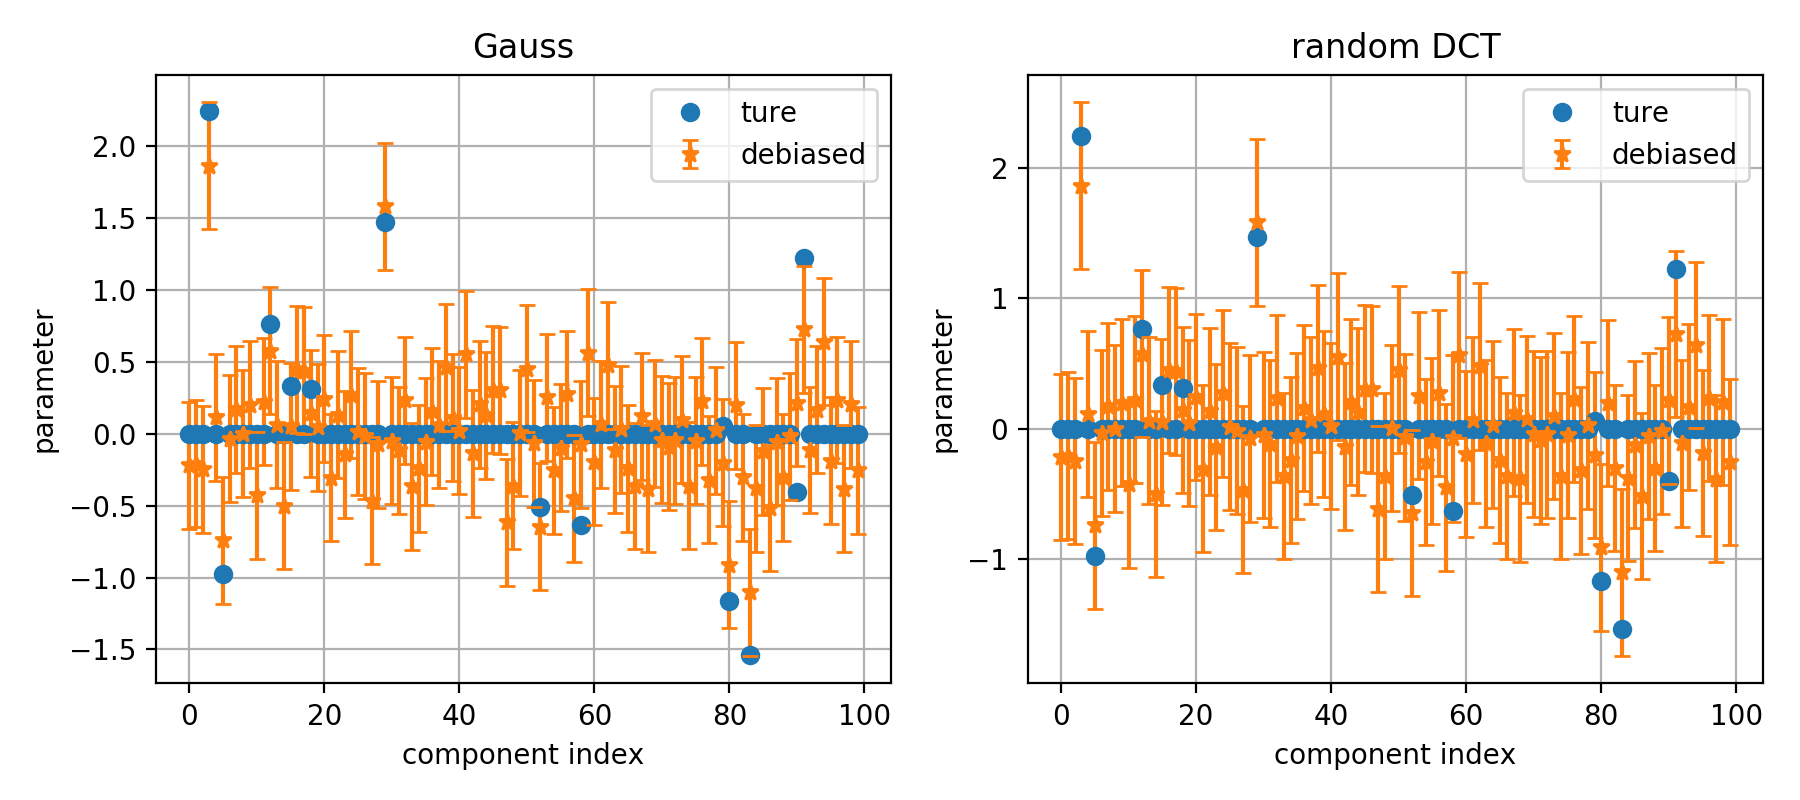

In [10]:
%matplotlib notebook

n_shown = 100

fig = plt.figure(figsize=(9, 4))
# gauss
ax = fig.add_subplot(121)
ax.plot(np.arange(n_shown), x_0[:n_shown], "o", label="ture")

yerr = np.ones(n_shown) * (np.sqrt(χ_hat_gauss) / Λ_gauss) * stats.norm.ppf(1.0-0.05/2.0, loc=0,scale=1)
ax.errorbar(np.arange(n_shown),
            x_debiased_gauss[:n_shown],
            yerr=yerr, 
            marker="*",linestyle="none", 
            capsize=3,
            label="debiased")
ax.set_xlabel("component index")
ax.set_ylabel("parameter")
ax.grid()
ax.legend()
ax.set_title("Gauss")

# dct
ax = fig.add_subplot(122)
ax.plot(np.arange(n_shown), x_0[:n_shown], "o", label="ture")

yerr = np.ones(n_shown) * (np.sqrt(χ_hat_dct) / Λ_dct) * stats.norm.ppf(1.0-0.05/2.0, loc=0,scale=1)
ax.errorbar(np.arange(n_shown),
            x_debiased_gauss[:n_shown],
            yerr=yerr, 
            marker="*",linestyle="none", 
            capsize=3,
            label="debiased")

ax.grid()
ax.legend()
ax.set_xlabel("component index")
ax.set_ylabel("parameter")
ax.set_title("random DCT")


fig.tight_layout()
